In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
sys.path.append('../')

from shopping_assistant.preprocessor import DataPreprocessor
import pandas as pd

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', None)
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
raw_data_path = "../data/FashionDataset.csv"
preprocessor = DataPreprocessor(raw_data_path)
preprocessor.process()
preprocessor.save("../data/clean_fashion_data.csv")
df = preprocessor.processed_data

In [3]:
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)

print("\n# let's look at the nan values")
print(df.isna().sum())

if "category" in df.columns:
    print("\n# category value counts")
    print(df["category"].value_counts())
else:
    print("\n# category column not found")

print("\n# describe")
print(df.describe(include="all"))

Columns: ['details', 'sizes', 'mrp', 'sell_price', 'discount_pct', 'sizes', 'sizes_count', 'brand', 'category', 'color_family', 'product_type', 'price_range', 'product_id']
Shape: (29575, 13)

# let's look at the nan values
details            0
sizes              0
mrp             7025
sell_price         0
discount_pct    7025
sizes              0
sizes_count        0
brand              0
category           0
color_family    1232
product_type       0
price_range        0
product_id         0
dtype: int64

# category value counts
category
Western Wear            9975
Indian Wear             9975
Lingerie & Nightwear    3225
Footwear                2475
Watches                 1725
Jewellery               1725
Fragrance                475
Name: count, dtype: int64

# describe
                                                                                     details  \
count                                                                                  29575   
unique                 

product_type rows that are lists (sample):
[['dress'], ['dress'], ['top'], ['dress'], ['jeans'], ['jeans'], ['dress'], ['top'], ['dress'], ['top']]


/var/folders/16/llhhg9l57rb1b34k1cw39gx80000gn/T/ipykernel_88480/3669543932.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index.astype(str), palette="tab20")


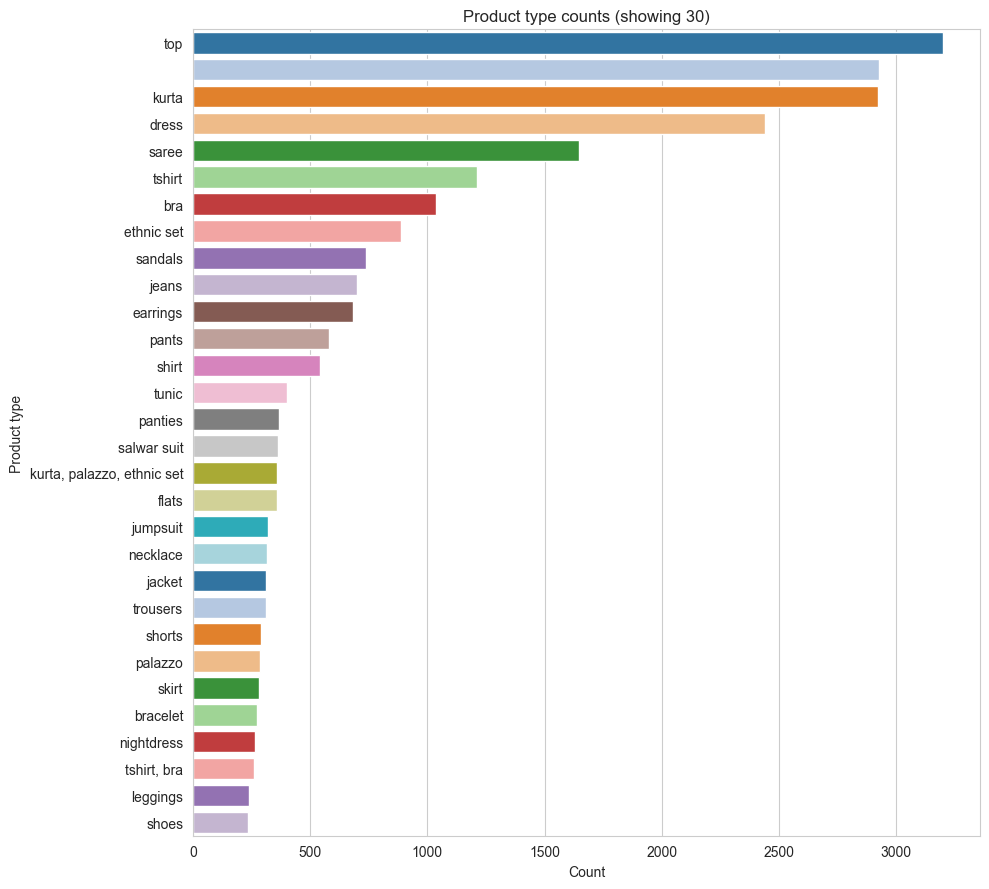

In [4]:
# debug: show any rows where product_type is a list/tuple
mask_list = df["product_type"].apply(lambda x: isinstance(x, (list, tuple)))
if mask_list.any():
    print("product_type rows that are lists (sample):")
    print(df.loc[mask_list, "product_type"].head(10).to_list())

# coerce list/tuple entries to a comma-joined string, keep other values as str
product_series = df["product_type"].fillna("missing").apply(
    lambda x: ", ".join(x) if isinstance(x, (list, tuple)) else str(x)
)

counts = product_series.value_counts()
TOP_N = 30
top = counts.head(TOP_N) if counts.shape[0] > TOP_N else counts

plt.figure(figsize=(10, max(4, 0.3 * len(top))))
sns.barplot(x=top.values, y=top.index.astype(str), palette="tab20")
plt.xlabel("Count")
plt.ylabel("Product type")
plt.title(f"Product type counts (showing {len(top)})")
plt.tight_layout()
plt.show()

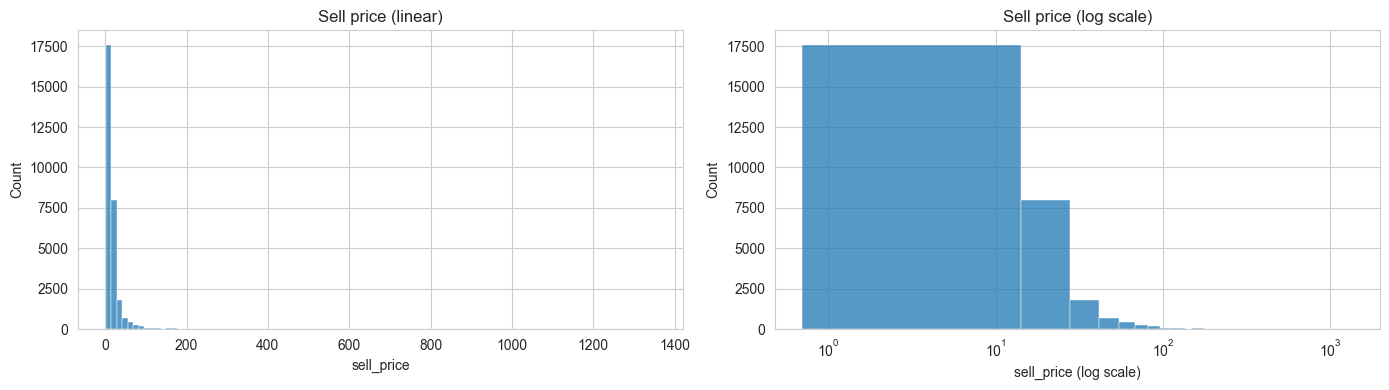

/var/folders/16/llhhg9l57rb1b34k1cw39gx80000gn/T/ipykernel_88480/1889936654.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brands.values, y=brands.index, palette="tab10")


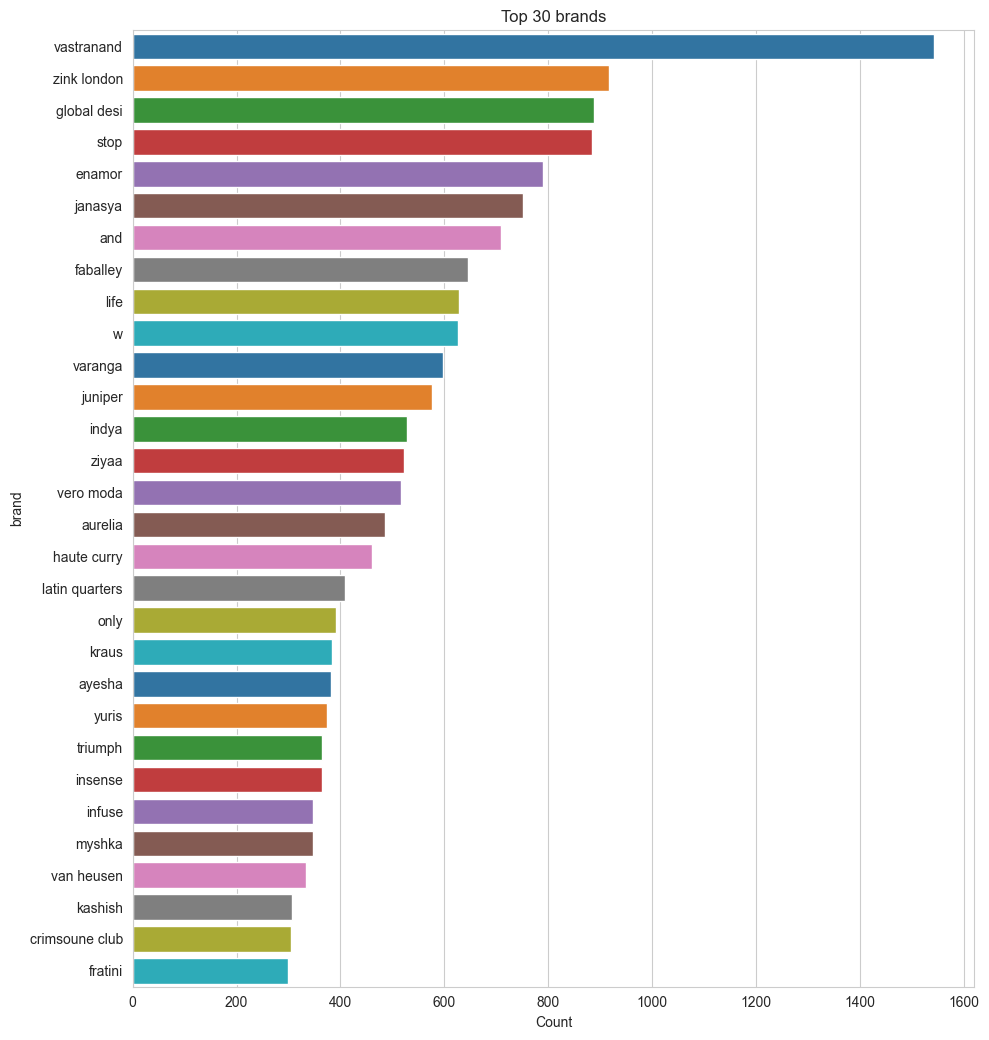

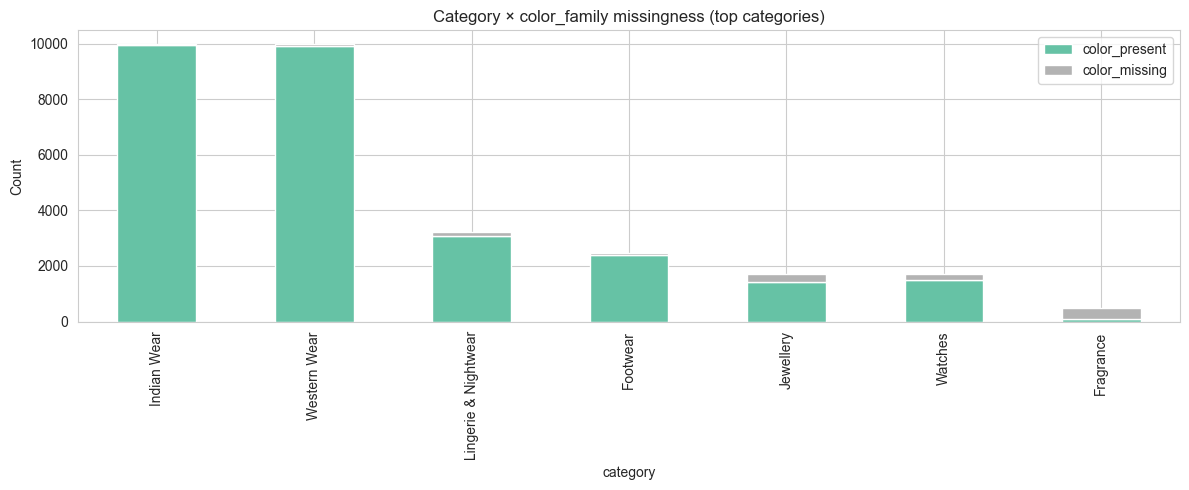

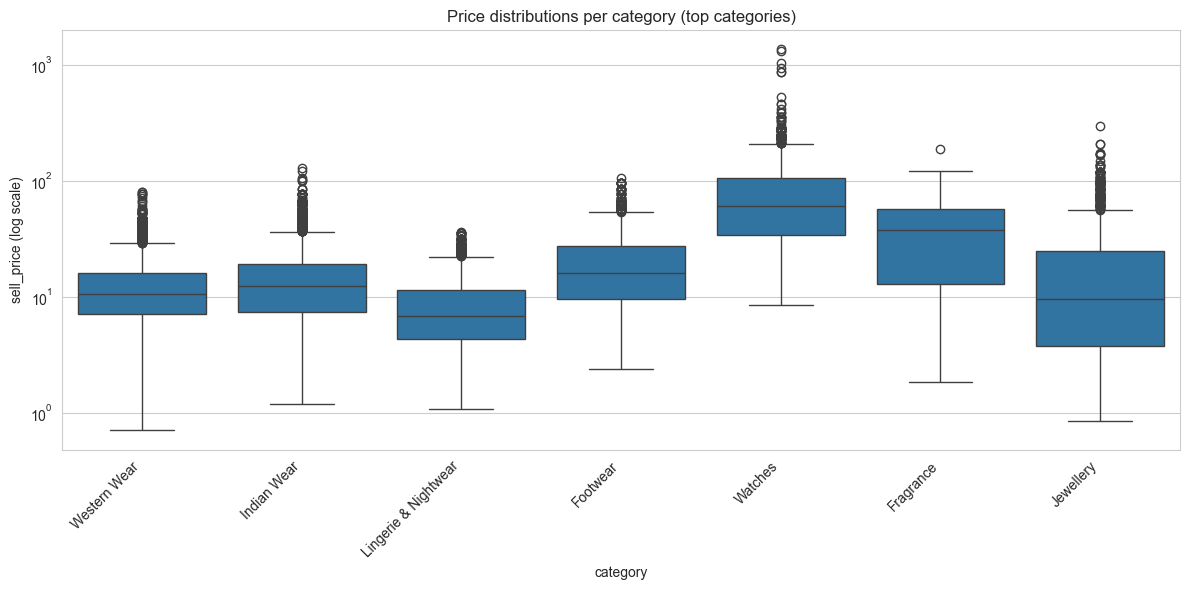

In [5]:
TOP_N = 30

# ensure numeric price column
df["sell_price_num"] = pd.to_numeric(df.get("sell_price", None), errors="coerce")

# 1) Histograms: linear + log (if wide range)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df["sell_price_num"].dropna(), bins=100, ax=axes[0], kde=False)
axes[0].set_title("Sell price (linear)")
axes[0].set_xlabel("sell_price")

sns.histplot(df["sell_price_num"].dropna(), bins=100, ax=axes[1], kde=False)
axes[1].set_xscale("log")
axes[1].set_title("Sell price (log scale)")
axes[1].set_xlabel("sell_price (log scale)")
plt.tight_layout()
plt.show()

# 2) Bar plot: top N brands
if "brand" in df.columns:
    brands = df["brand"].fillna("missing").astype(str).value_counts().head(TOP_N)
    plt.figure(figsize=(10, max(4, 0.35 * len(brands))))
    sns.barplot(x=brands.values, y=brands.index, palette="tab10")
    plt.xlabel("Count")
    plt.title(f"Top {len(brands)} brands")
    plt.tight_layout()
    plt.show()
else:
    print("brand column not found")

# 3) Stacked bar: category × missingness of color_family
if "category" in df.columns and "color_family" in df.columns:
    ct = pd.crosstab(df["category"].fillna("missing"), df["color_family"].isna())
    # rename columns for clarity
    ct.columns = ["color_present", "color_missing"]
    # keep top categories for readability
    top_cats = ct.sum(axis=1).sort_values(ascending=False).head(15).index
    ct_top = ct.loc[top_cats]
    ct_top.plot(kind="bar", stacked=True, figsize=(12, 5), colormap="Set2")
    plt.ylabel("Count")
    plt.title("Category × color_family missingness (top categories)")
    plt.tight_layout()
    plt.show()
else:
    print("category or color_family column not found")

# 4) Boxplots: price distribution per category (top categories)
if "category" in df.columns:
    # pick categories with enough samples
    cat_counts = df["category"].value_counts()
    top_categories = cat_counts[cat_counts >= 20].index[:10]  # at least 20 samples, max 10 cats
    box_df = df.loc[df["category"].isin(top_categories), ["category", "sell_price_num"]].dropna()
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x="category", y="sell_price_num", data=box_df)
    ax.set_yscale("log")  # use log y to make distributions comparable and reduce outlier skew
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("sell_price (log scale)")
    plt.title("Price distributions per category (top categories)")
    plt.tight_layout()
    plt.show()
else:
    print("category column not found")